In [1]:
import numpy as np
import pandas as pd
import os
import glob
import scipy.stats as stats
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests

In [13]:
### 1. real data (Pearson syndrome)
file_path = "/Users/harukonakagawa/Desktop/mtDNA/250128_psrna20K-20M_plot/last_result/indel.nomap.noref.last.breakspan.tsv"
df = pd.read_csv(file_path, sep="\t")
print(df.head())

                      name  break5  break3  delread  wtread  heteroplasmy
0  SRR14433337_10000000_s1    4863    5263        1     645      0.154799
1  SRR14433337_10000000_s1   15638   15741        1    2776      0.036010
2  SRR14433337_10000000_s1   12909   13077        1      40      2.439024
3  SRR14433337_10000000_s1   13307   14542        1     211      0.471698
4  SRR14433337_10000000_s1   12848   14615        1     170      0.584795


In [14]:
# Calculate total depth
df["total_depth"] = df["delread"] + df["wtread"]

# print number of variant
row_count = len(df)
print(f"all row: {row_count}")

all row: 276


In [15]:
# As base error, variant with heteroplasmy < 1% are assumed to be error
be_df = df[df["heteroplasmy"] < 1] 
total_depths = be_df["total_depth"]
alt_depths = be_df["delread"]

# print number of variant
row_count = len(be_df)
print(f"base error row: {row_count}")

base error row: 156


In [16]:
# Calculate mean and variance of error
error_rates = alt_depths / total_depths
mean_error = np.mean(error_rates)
var_error = np.var(error_rates)

# Estimate α, β (Beta-distribution) by a method of moments
alpha = mean_error * ((mean_error * (1 - mean_error) / var_error) - 1)
beta = (1 - mean_error) * ((mean_error * (1 - mean_error) / var_error) - 1)
print(f"Estimated beta distribution parameter: alpha={alpha:.3f}, beta={beta:.3f}")

Estimated beta distribution parameter: alpha=0.636, beta=350.771


In [17]:
# Remove deletions with few support reads (WT read = 0 or del read = 1)
df = df.loc[(df['wtread'] != 0) & (df['delread'] != 1)]

# print number of variant
row_count = len(df)
print(f"filtered row (removed WT read = 0 or del read = 1): {row_count}")

filtered row (removed WT read = 0 or del read = 1): 44


In [18]:
# Calculate p value by Beta-Binomial model
def beta_binomial_pval(total_depth, alt_depth, alpha, beta):
    """
    Calculate P value using Beta-Binomial model
    - Find the probability that del read > alt_depth
    """
    return 1 - stats.betabinom.cdf(alt_depth - 1, total_depth, alpha, beta)

In [19]:
# Calculate and append p value col
df["p_value"] = df.apply(lambda row: beta_binomial_pval(row["total_depth"], row["delread"], alpha, beta), axis=1)
df.head()

In [20]:
# Calculate q value with Benjamini-Hochberg
df["q_value"] = multipletests(df["p_value"], method="fdr_bh")[1]
df.head()

,name,break5,break3,delread,wtread,heteroplasmy,total_depth,p_value,q_value
5,SRR14433337_10000000_s1,6072,13094,59,22,72.839506,81,5.555556e-13,1.111111e-12
6,SRR14433337_10000000_s2,6072,13094,60,19,75.949367,79,3.067546e-13,7.103791e-13
14,SRR14433337_10000000_s3,6072,13094,56,20,73.684211,76,5.750955e-14,4.217367e-13
17,SRR14433337_10000000_s4,6072,13094,58,20,74.358974,78,1.900702e-13,6.433145e-13
21,SRR14433337_10000000_s5,6072,13094,60,22,73.170732,82,0.000000e+00,0.000000e+00


In [21]:
# Filtering
threshold = 0.01  # FDR threshold (adjustable)

df["PASS"] = df["q_value"] < threshold

# print number of variant
true_count = (df["PASS"] == True).sum()
false_count = (df["PASS"] == False).sum()
print(f"PASS count: {true_count}, False positive count: {false_count}")

PASS count: 41, False positive count: 3


In [22]:
# Print results
print(df.to_string())

                        name  break5  break3  delread  wtread  heteroplasmy  total_depth       p_value       q_value   PASS
5    SRR14433337_10000000_s1    6072   13094       59      22     72.839506           81  5.555556e-13  1.111111e-12   True
6    SRR14433337_10000000_s2    6072   13094       60      19     75.949367           79  3.067546e-13  7.103791e-13   True
14   SRR14433337_10000000_s3    6072   13094       56      20     73.684211           76  5.750955e-14  4.217367e-13   True
17   SRR14433337_10000000_s4    6072   13094       58      20     74.358974           78  1.900702e-13  6.433145e-13   True
21   SRR14433337_10000000_s5    6072   13094       60      22     73.170732           82  0.000000e+00  0.000000e+00   True
26    SRR14433337_1000000_s1    6072   13094        3       1     75.000000            4  2.485533e-07  3.124670e-07   True
28    SRR14433337_1000000_s2    6072   13094        5       4     55.555556            9  1.001568e-09  1.468966e-09   True
29    SR

In [25]:
# ground truth labal
valid_pairs = {(6072, 13094), (8469, 13446), (10381, 15406)}
df["answer"] = df.apply(lambda row: (row["break5"], row["break3"]) in valid_pairs, axis=1)

# Save data
df.to_csv('250218_psrna_betabinomial_rmfirst_fdr0.01.tsv', sep='\t', index=False)

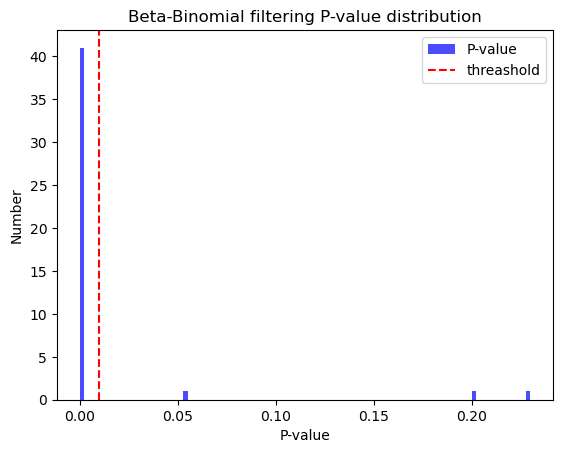

In [26]:
# Histogram visualization
# plot
plt.hist(df["p_value"], bins=100, alpha=0.7, color="blue", label="P-value")
plt.axvline(threshold, color='red', linestyle="--", label="threashold")
plt.xlabel("P-value")
plt.ylabel("Number")
plt.legend()
plt.title("Beta-Binomial filtering P-value distribution")
plt.show()